# Day-Ahead Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, Model

import preprocessing       
import models
import utils
import plotting

/Users/viktorwalter/Code/Forecasting/forecasting_framework/frcst/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.3
Numpy version: 2.1.3
Tensorflow version: 2.19.0


In [3]:
# paths
data_dir = '../../Daten'
data_file = '1B_Trina.csv'

# model params
output_dim = 48
batch_size = 128
learning_rate = 0.001
epochs = 20
hpo = False
persistence_model = '2daysago'

# data params
timestamp_col = 'timestamp'
target_col = 'Active_Power'
freq = 'h'
train_end = '2017-12-31'
test_start = '2018-01-01'
lag_dim = 24 * 2
horizon = 48
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False
return_index = True

# more params
evaluate_on_all_test_data = False
rel_features = [target_col, 
                'Global_Horizontal_Radiation',
                'Diffuse_Horizontal_Radiation', 
                'Weather_Temperature_Celsius', 
                'Weather_Relative_Humidity']

path = os.path.join(data_dir, data_file)

In [4]:
# read data
df = preprocessing.preprocess_1b_trina(path=path,
                                       timestamp_col=timestamp_col,
                                       freq=freq,
                                       rel_features=rel_features)

#df = clean()
# drop rows where all columns are NaN
df.drop(df[df.isnull().any(axis=1)].index, inplace=True)

# create temporal features
df = preprocessing.lag_features(df=df, 
                                target_col=target_col,
                                lag_dim=lag_dim,
                                horizon=horizon,
                                lag_in_col=lag_in_col)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43775 entries, 2014-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Active_Power                  43775 non-null  float64
 1   Global_Horizontal_Radiation   43775 non-null  float64
 2   Diffuse_Horizontal_Radiation  43775 non-null  float64
 3   Weather_Temperature_Celsius   43775 non-null  float64
 4   Weather_Relative_Humidity     43775 non-null  float64
 5   lag_48h                       43727 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB


In [6]:
windows = preprocessing.prepare_data(data=df,
                                     train_end=train_end,
                                     test_start=test_start,
                                     output_dim=output_dim,
                                     target_col=target_col,
                                     scale_y=scale_y,
                                     return_index=return_index)
X_train, y_train, X_test, y_test = windows[0], windows[1], windows[2], windows[3]
if return_index:
    index_train, index_test = windows[4], windows[5]
scaler_y = None
if scale_y:
    scaler_y = windows[6]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(34920, 48, 5) (34920, 48) (8713, 48, 5) (8713, 48)


In [7]:
#hyperparameters = load_hp()

n_features = X_train.shape[2]

# Model
model = models.tcn(n_features, output_dim)
model.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['mae'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 16)         │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 48)             │        73,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,008 (293.00 KB)

 Trainable params: 75,008 (293.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', options=None, save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 'auto',
    #callbacks = callbacks,
    #validation_split = 0.3,
    shuffle = False
)

#model = keras.models.load_model('models/best.keras')

Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 30.2333 - mae: 3.7443
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4150 - mae: 1.8123
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9982 - mae: 1.5882
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4798 - mae: 1.5062
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3580 - mae: 1.4945
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3665 - mae: 1.5044
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3637 - mae: 1.5104
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2622 - mae: 1.4955
Epoch 9/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0236 - mae: 1.4497
Epoch 10/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7439 - mae: 1.3885
Epoch 11/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5376 - mae: 1.3377
Epoch 12/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3574 - mae: 1.2927
Epoch 13/20
273/273 ━━━━

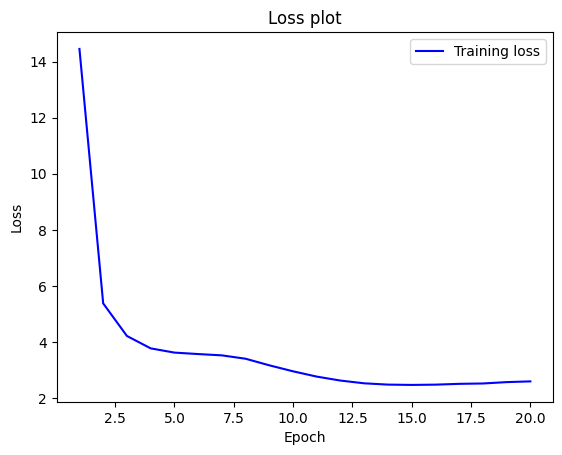

In [10]:
plotting.plot_training(history=history,
                       validation=False,
                       save_name=None)

In [11]:
y_true, y_pred = utils.get_y(X_test=X_test,
                             y_test=y_test,
                             output_dim=output_dim,
                             scaler_y=scaler_y,
                             model=model)
df_pred = utils.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = utils.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


In [12]:
persistence = utils.benchmark_models(data=df,
                                     target_col=target_col,
                                     horizon=horizon,
                                     train_end=train_end,
                                     test_start=test_start,
                                     output_dim=output_dim,
                                     index_test=index_test,
                                     t_0=None if evaluate_on_all_test_data else t_0)

In [13]:
results = utils.evaluate_models(pred=df_pred,
                                true=df_true,
                                persistence=persistence,
                                persistence_model=persistence_model)
results

,R^2,RMSE,MAE,Skill
Models,,,,
Main,0.878014,1.729951,1.013864,0.135388
2daysago,0.836820,2.000842,0.922861,0.000000
LinearRegression,0.723231,2.605786,1.651344,-0.302345


R^2: 0.9207614762659366
RMSE: 1.6784813138956878
MAE: 1.032013086770241


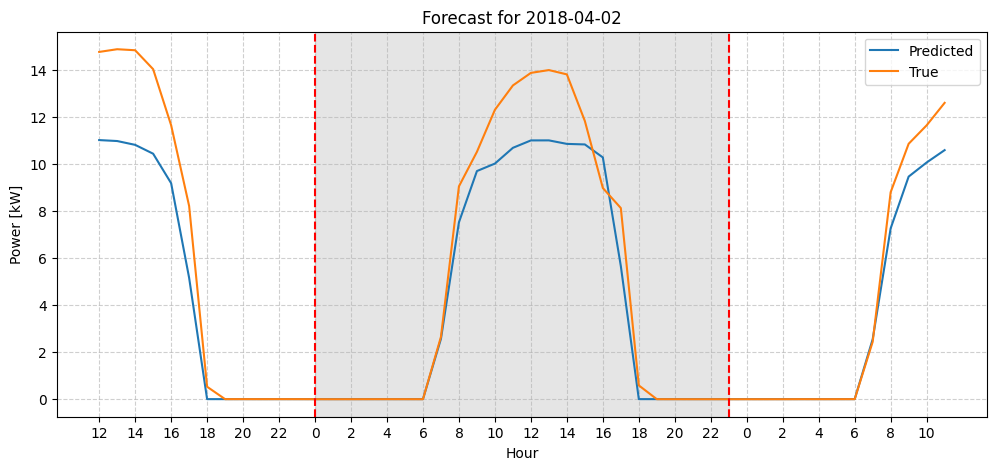

In [14]:
#date = '2018-06-06'
date = plotting.random_date(start_date=test_start, 
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

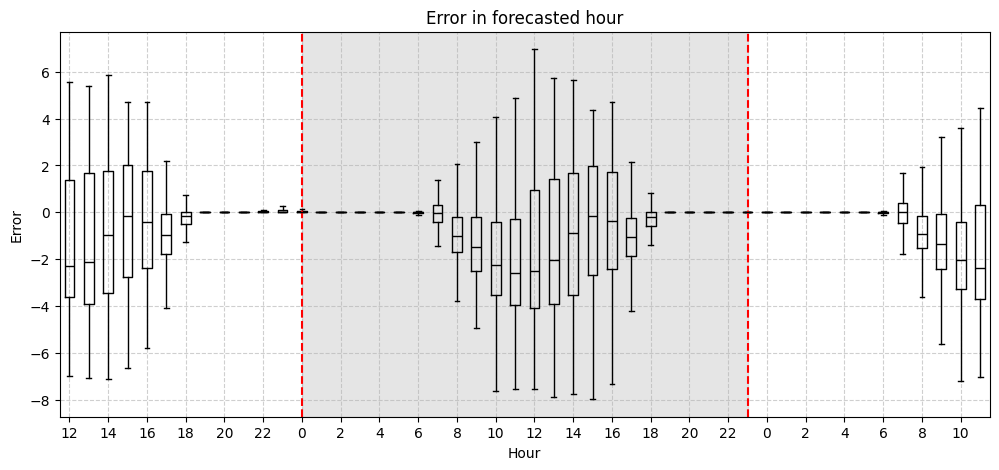

In [15]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

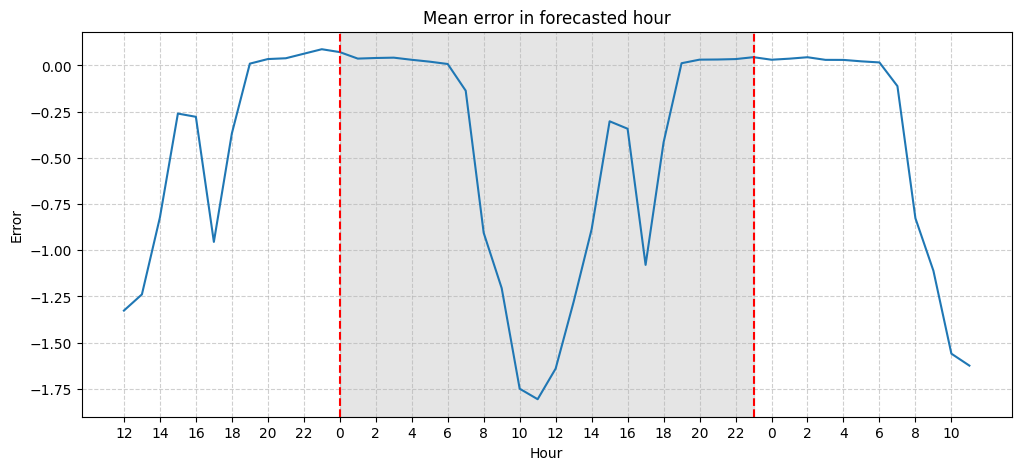

In [16]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

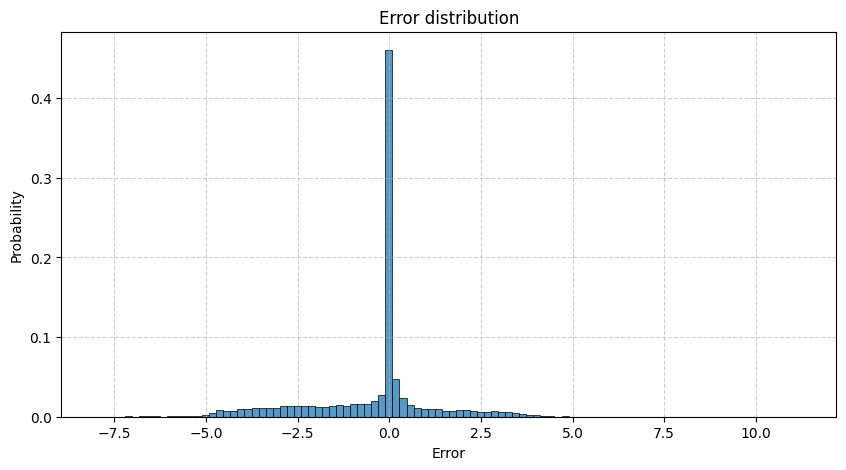

In [17]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)